In [1]:
#IMPORTING LIBRARIES
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import zfit
import zfit.z.numpy as znp
import zfit_physics as zphysics 
from zfit import z  
import tensorflow as tf
import uproot
from matplotlib.gridspec import GridSpec

/Users/khrystina/new_env/lib/python3.11/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
#SELECTION DEFINITION

THE_BIG_SELECTION = (
    "((Dst_M - D0_M) > 143) & ((Dst_M - D0_M) < 148) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 1.7) & (pi_TRACK_CHI2NDOF < 1.7) & "
    "(K_PT > 250) & (pi_PT > 250) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 2) & "
    "(mm_TRACK_CHI2NDOF < 2) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 700) & (mm_PT > 700) & "
    "(mp_IPCHI2_OWNPV > 2) & (mm_IPCHI2_OWNPV > 2) & "
    "(Jpsi_M < 3140) & (Jpsi_M > 3040) & "
    "(pi_soft_PT > 250) & "
    "(Bc_ENDVERTEX_CHI2 < 4.2) & "
    "(Bc_IPCHI2_OWNPV < 10) & "
    "(Bc_DIRA_OWNPV > 0.99)"
)

In [3]:
#DATA DOWNLOADING
files_simu = [
    './simulation/2011_MagDown.root', 
    './simulation/2015_MagDown.root',
    './simulation/2015_MagUp.root',
    './simulation/2016_MagDown.root',
    './simulation/2016_MagUp.root',
    './simulation/2017_MagDown.root',
    './simulation/2017_MagUp.root',
    './simulation/2018_MagDown.root',
    './simulation/2018_MagUp.root'
]

files_real_data = [
    './real_data/2011_MagDown.root', 
    './real_data/2011_MagUp.root',
    './real_data/2012_MagDown.root', 
    './real_data/2012_MagUp.root',
    './real_data/2015_MagDown.root', 
    './real_data/2015_MagUp.root',
    './real_data/2016_MagDown.root', 
    './real_data/2016_MagUp.root',
    './real_data/2017_MagDown.root', 
    './real_data/2017_MagUp.root',
    './real_data/2018_MagDown.root', 
    './real_data/2018_MagUp.root'
]
simu_data = uproot.concatenate(files_simu, cut = f"{THE_BIG_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{THE_BIG_SELECTION} & ((Bc_FullDTF_M < 6250.) | (Bc_FullDTF_M > 6300.))", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_2891/2903014781.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_2891/2903014781.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


In [21]:
#FUNCTION FOR PLOTTING
def plot_model_with_pulls(model, name, data, min, max, scale=1, nbins=50, plot_data=True):
    
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = np.linspace(lower, upper, num=1000)

    # Evaluate model PDF
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    fig = plt.figure(figsize=(8, 6))

    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 

    # Upper subplot: Model and Data with error bars
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x, y, label="model", color="blue", linewidth=1)
    ax1.set_xlim(min, max)

    if plot_data:
        # Bin the data
        data_binned = data.to_binned(nbins)
        bin_centers = data_binned.axes[0].centers
        bin_widths = data_binned.axes[0].widths
        data_counts = data_binned.values()
        data_uncertainties = np.sqrt(data_counts)  # Poisson errors

        ax1.errorbar(
            bin_centers, data_counts, yerr=data_uncertainties, fmt='o', 
            color='orange', label="data", markersize=1, capsize=2
        )

    ax1.legend()
    ax1.set_ylabel("Counts")
    
    ax1.set_title(name)
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if plot_data:
        # Compute pulls
        model_at_bins = model.pdf(bin_centers) * size_normal / nbins * data.data_range.volume
        pulls = (data_counts - model_at_bins) / data_uncertainties

        ax2.errorbar(
            bin_centers, pulls, yerr=1, fmt='o', 
            color='purple', label="pulls", markersize=1, capsize=2
        )
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.set_ylim(-10, 10) 
        ax2.set_ylabel("Pulls")
        ax2.grid()
        ax2.legend()
    ax2.set_xlabel("Observable")
    plt.tight_layout()
    plt.show()

In [22]:
#FUNCTION FOR PLOTTING
def plot_model_with_pulls_log(model, name, data, min, max, scale=1, nbins=50, plot_data=True):
    
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = np.linspace(lower, upper, num=1000)

    # Evaluate model PDF
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    fig = plt.figure(figsize=(8, 6))

    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 

    # Upper subplot: Model and Data with error bars
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x, y, label="model", color="blue", linewidth=1)
    ax1.set_xlim(min, max)

    if plot_data:
        # Bin the data
        data_binned = data.to_binned(nbins)
        bin_centers = data_binned.axes[0].centers
        bin_widths = data_binned.axes[0].widths
        data_counts = data_binned.values()
        data_uncertainties = np.sqrt(data_counts)  # Poisson errors

        ax1.errorbar(
            bin_centers, data_counts, yerr=data_uncertainties, fmt='o', 
            color='orange', label="data", markersize=1, capsize=2
        )

    ax1.legend()
    ax1.set_ylabel("Counts")
    
    ax1.set_title(name)
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if plot_data:
        # Compute pulls
        model_at_bins = model.pdf(bin_centers) * size_normal / nbins * data.data_range.volume
        pulls = (data_counts - model_at_bins) / data_uncertainties

        ax2.errorbar(
            bin_centers, pulls, yerr=1, fmt='o', 
            color='purple', label="pulls", markersize=1, capsize=2
        )
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.set_ylim(-10, 10) 
        ax2.set_ylabel("Pulls")
        ax2.grid()
        ax2.legend()
    ax1.set_yscale('log')
    ax2.set_xlabel("Observable")
    plt.tight_layout()
    plt.show()

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_2891/526329052.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


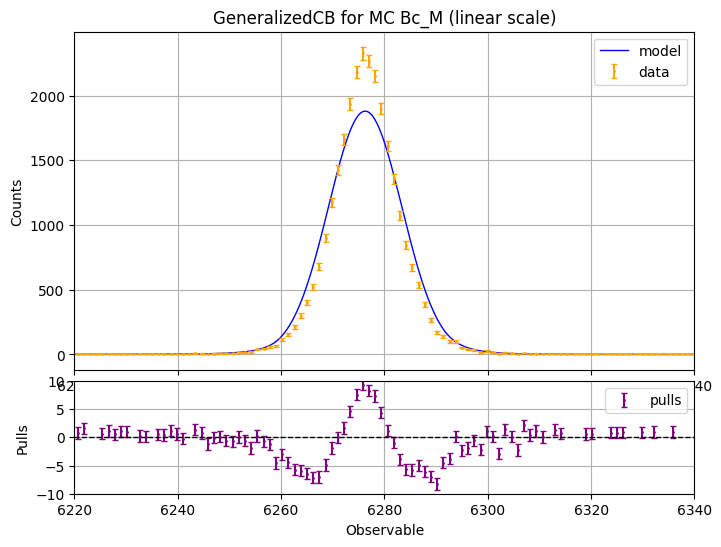

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_2891/587112544.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


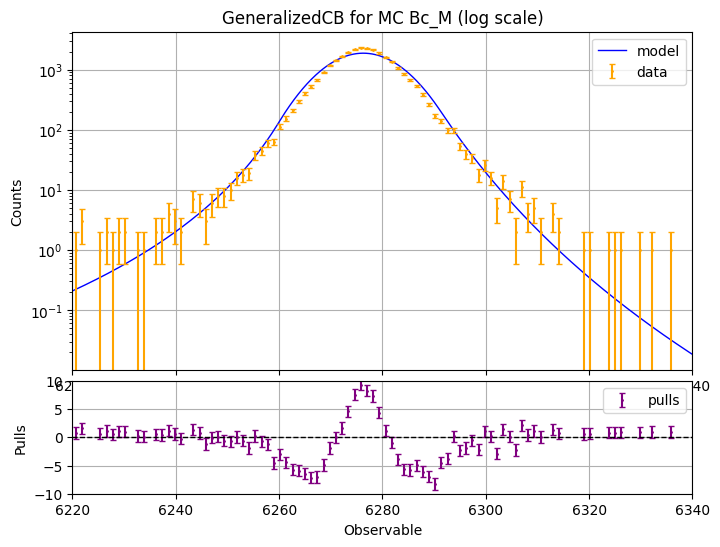

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.physics.GeneralizedCB'>  params=[alpha_gcb_l, alpha_gcb_r, mu_gcb, n_gcb_l, n_gcb_r, sigma_gcb_l, sigma_gcb_r]] data=[<zfit.Data: Data obs=('mass',) shape=(28143, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  False  │    True     │       True       │ 0.00031 │         93990.62 | -5285.349 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
mu_gcb                  6276.28       False
sigma_gcb_l                 7.1        True
alpha_gcb_l             2.30522       False
n_gcb_l                     5.1        True
sigma_gcb_r       

In [29]:
#GENERALIZEDCRYSTALLBALL
# Parameters
simu_mass = simu_data['Bc_FullDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(6220, 6340))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_gcb = zfit.Parameter('mu_gcb', 6278.4, 6259, 6290)
sigma_gcb_l = zfit.Parameter('sigma_gcb_l', 17.4, 7.1, 25)
sigma_gcb_r = zfit.Parameter('sigma_gcb_r', 17.4, 7.1, 25)
alpha_gcb_l = zfit.Parameter('alpha_gcb_l', 1.5, 0.1, 5)
n_gcb_l = zfit.Parameter('n_gcb_l', 32., 5.1, 50)
alpha_gcb_r = zfit.Parameter('alpha_gcb_r', 1.9, 0.1, 5)
n_gcb_r = zfit.Parameter('n_gcb_r', 32., 11.1, 770)
# Define the PDF (gcb profile)
gcb = zfit.pdf.GeneralizedCB(obs=mass_obs, mu=mu_gcb, sigmal=sigma_gcb_l, sigmar=sigma_gcb_r, alphal=alpha_gcb_l, nl=n_gcb_l, alphar=alpha_gcb_r, nr=n_gcb_r)

# Loss function (Unbinned NLL)
nll_gcb = zfit.loss.UnbinnedNLL(model=gcb, data=simu_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result_gcb = minimizer_minuit.minimize(loss=nll_gcb)

# Plot result
plot_model_with_pulls(gcb, "GeneralizedCB for MC Bc_M (linear scale)", simu_data_zfit, 6220, 6340, nbins=100)
plot_model_with_pulls_log(gcb, "GeneralizedCB for MC Bc_M (log scale)", simu_data_zfit, 6220, 6340, nbins=100)

print(result_gcb)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_2891/526329052.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


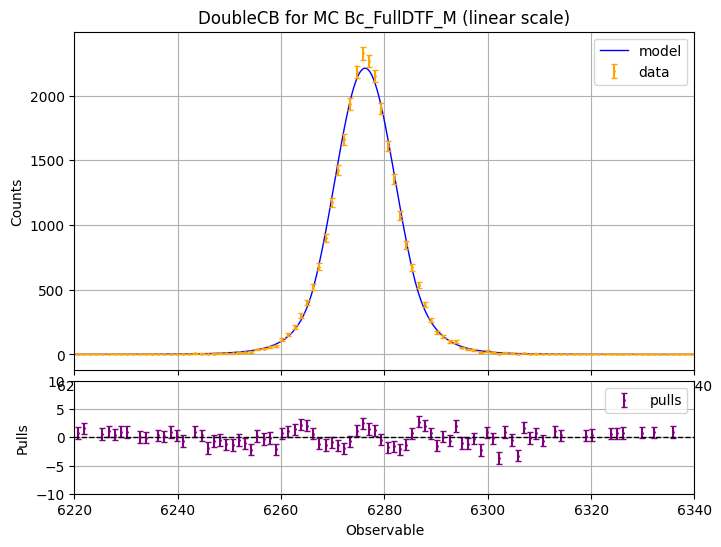

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_2891/587112544.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


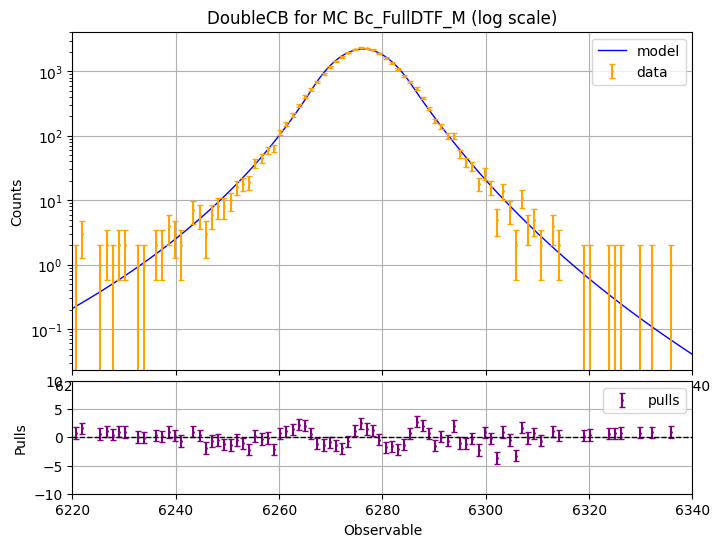

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.physics.DoubleCB'>  params=[alpha_dcb_l, alpha_dcb_r, mu_dcb, n_dcb_l, n_dcb_r, sigma_dcb]] data=[<zfit.Data: Data obs=('mass',) shape=(28143, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 9.9e-06 │         93596.85 |  9990.508 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
mu_dcb                  6276.26       False
sigma_dcb               5.86135       False
alpha_dcb_l             1.70457       False
n_dcb_l                 7.76973       False
alpha_dcb_r             1.60865       

In [39]:
#DoubleCRYSTALLBALL
# Parameters
simu_mass = simu_data['Bc_FullDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(6220, 6340))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_dcb = zfit.Parameter('mu_dcb', 6276.4, 6259, 6290)
sigma_dcb = zfit.Parameter('sigma_dcb', 5.8, 1.1, 19)
alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 1.7, 0.1, 5)
n_dcb_l = zfit.Parameter('n_dcb_l', 8., 5.1, 50)
alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 1.6, 0.1, 5)
n_dcb_r = zfit.Parameter('n_dcb_r', 11., 7.1, 15)
# Define the PDF (dcb profile)
dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu_dcb, sigma=sigma_dcb, alphal=alpha_dcb_l, nl=n_dcb_l, alphar=alpha_dcb_r, nr=n_dcb_r)

# Loss function (Unbinned NLL)
nll_dcb = zfit.loss.UnbinnedNLL(model=dcb, data=simu_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result_dcb = minimizer_minuit.minimize(loss=nll_dcb)

# Plot result
plot_model_with_pulls(dcb, "DoubleCB for MC Bc_FullDTF_M (linear scale)", simu_data_zfit, 6220, 6340, nbins=100)
plot_model_with_pulls_log(dcb, "DoubleCB for MC Bc_FullDTF_M (log scale)", simu_data_zfit, 6220, 6340, nbins=100)

print(result_dcb)
